In [1]:
import os
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings
from langchain_chroma import Chroma
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools import DuckDuckGoSearchRun

load_dotenv()
nvidia_api_key = os.getenv("NVIDIA_API_KEY")

llm = ChatNVIDIA(model="meta/llama3-70b-instruct")
parser = StrOutputParser()


embeddings = NVIDIAEmbeddings(
    model="nvidia/nv-embedqa-e5-v5",
    model_type="passage",
    api_key=nvidia_api_key
)
vector_store = Chroma(
    persist_directory='hands-on-ml',
    embedding_function = embeddings,
    collection_name='hands-on-ml1'
)


class Agentstste(TypedDict):
    question: str
    docs: str
    grade_response: str
    answer: str


# Retrieve node
def retrive_docs(state: Agentstste):
    print('Node: Retrieve Docs')
    retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 30})
    docs = retriever.invoke(state["question"])
    state["docs"] = "\n\n".join(doc.page_content for doc in docs)
    return state

# grade node
def grade(state: Agentstste):
    print('\nNode: Grade Context')
    prompt = PromptTemplate(
        template="""You are a DAA expert. Decide if the retrieved context is relevant to the question.

        Question:
        {question}

        Context:
        {retrieved_docs}

        Respond ONLY with "yes" or "no".
        """, input_variables=['question', 'retrieved_docs']
    )
    chain = prompt | llm | parser
    result = chain.invoke({'question': state['question'], 'retrieved_docs': state['docs']})
    state['grade_response'] = result
    return state

def grade_condition(state: Agentstste) -> str:
    return state["grade_response"]

# web search node
def web_search(state : Agentstste):
    print('\n web search node')
    search = DuckDuckGoSearchRun()
    state['docs'] = search.invoke(state['question'])
    return state

# answer generation node
def generate_answer(state: Agentstste):
    print('\n Node: Generate Answer')
    prompt = PromptTemplate(
        template="""You are a  professor. Use only the given context to answer the question.

        Question:
        {question}

        Lecture Notes Context:
        {retrieved_docs}

        Write clearly using examples, formulas, and structured explanation.
        """, input_variables=['question', 'retrieved_docs']
    )
    chain = prompt | llm | parser
    state['answer'] = chain.invoke({'question': state['question'], 'retrieved_docs': state['docs']})
    return state

#Building Graph
graph = StateGraph(Agentstste)

graph.add_node("retrive_docs", retrive_docs)
graph.add_node("grade", grade)
graph.add_node("web_search", web_search)
graph.add_node("generate_answer", generate_answer)

graph.add_edge(START, 'retrive_docs')
graph.add_edge('retrive_docs', 'grade')
graph.add_conditional_edges(
    "grade", grade_condition, 
    {
    "yes": "generate_answer",
    "no": "web_search"
    }
)
graph.add_edge('generate_answer', END)
graph.add_edge('web_search', 'generate_answer')

app = graph.compile()

initial_state = Agentstste(question='what is the difference between supervised and unsupervised learning?')
response = app.invoke(initial_state)

print("\n🔎 Final Question:", response['question'])
# print("\n Retrieved docs:",response['docs'])
print("📘 Final Answer:\n", response['answer'])

# from IPython.display import Image, display
# display(Image(app.get_graph().draw_mermaid_png()))

Node: Retrieve Docs

Node: Grade Context

 web search node

 Node: Generate Answer

🔎 Final Question: what is the difference between supervised and unsupervised learning?
📘 Final Answer:
 The fundamental difference between supervised and unsupervised learning lies in their approach to data and objectives.

**Supervised Learning:**

In supervised learning, the model is trained on a labeled dataset, where each input is paired with a corresponding output label. The primary goal is to learn the relationship between inputs and outputs, enabling the model to predict outcomes for new, unseen data.

**Key Characteristics:**

1. **Labeled Data**: The training data has predefined labels.
2. **Learn to Predict**: The model learns to predict outcomes based on the labeled data.

**Example:** Classifying emails as spam or not spam. The model is trained on a labeled dataset, where each email is labeled as either "spam" or "not spam." The goal is to learn the patterns that distinguish spam from non-sp

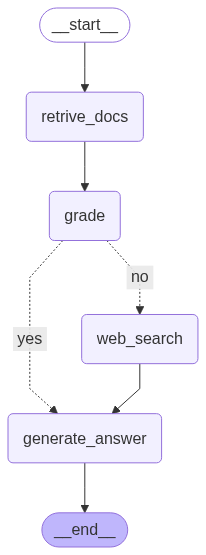

In [2]:

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))